# Example using the `DANN` class defined in this module

## Data

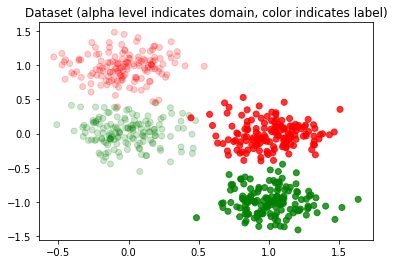

In [1]:
%matplotlib inline

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

X_source, y_source = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
X_target, y_target = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

plt.scatter(X_source[:,0], X_source[:,1], c=[["g", "r"][k] for k in y_source], alpha=0.2)
plt.scatter(X_target[:,0], X_target[:,1], c=[["g", "r"][k] for k in y_target],  alpha=0.8)
plt.title("Dataset (alpha level indicates domain, color indicates label)");

## Model parts

We are now ready to build our model to be trained with DANN strategy.
Let us first build its parts.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

latent_space_dim = 16

feature_extractor = Sequential([
    Dense(units=latent_space_dim, activation="relu", input_dim=2),
    Dense(units=latent_space_dim, activation="relu")
])
classifier = Sequential([
    Dense(units=latent_space_dim, activation="relu", input_dim=latent_space_dim),
    Dense(units=1, activation="sigmoid")
])
domain_classifier = Sequential([
    Dense(units=latent_space_dim, activation="relu", input_dim=latent_space_dim),
    Dense(units=1, activation="sigmoid")
])


Now we can define our DANN model on top of those parts:

In [3]:
from kerasDANN import DANN

model = DANN(
    feature_extractor=feature_extractor,
    label_predictor=classifier,
    domain_classifier=domain_classifier,
    loss_lambda=2.
)

In [4]:
from sklearn.metrics import accuracy_score

model.label_model_.fit(X_source, y_source, epochs=10, verbose=0)
acc_source = accuracy_score(y_source, model(X_source) > 0.5)
print(f"10 epochs done, source accuracy={acc_source}, no DA yet")

10 epochs done, source accuracy=0.9933333333333333, no DA yet


In [5]:
from sklearn.metrics import accuracy_score

for n_repeats in range(10):
    model.fit((X_source, X_target), y_source, epochs=10)
    acc_source = accuracy_score(y_source, model(X_source) > 0.5)
    acc_target = accuracy_score(y_target, model(X_target) > 0.5)
    print(f"10 epochs done, source accuracy={acc_source}, target accuracy={acc_target}")
    


10 epochs done, source accuracy=0.9933333333333333, target accuracy=0.5033333333333333
10 epochs done, source accuracy=0.9866666666666667, target accuracy=0.5033333333333333
10 epochs done, source accuracy=0.9833333333333333, target accuracy=0.58
10 epochs done, source accuracy=0.9866666666666667, target accuracy=0.5833333333333334
10 epochs done, source accuracy=0.99, target accuracy=0.7866666666666666
10 epochs done, source accuracy=0.99, target accuracy=0.7866666666666666
10 epochs done, source accuracy=0.9866666666666667, target accuracy=0.5333333333333333
10 epochs done, source accuracy=0.9933333333333333, target accuracy=0.9
10 epochs done, source accuracy=0.9933333333333333, target accuracy=0.8766666666666667
10 epochs done, source accuracy=0.9933333333333333, target accuracy=0.91


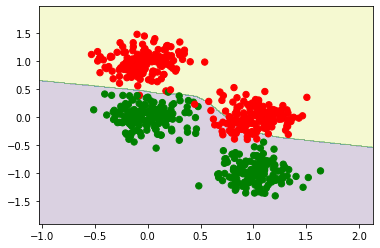

In [6]:
def plot_decision(clf, X, y):
    # Build a 2D grid and perform classification using clf on this grid
    xx, yy = np.meshgrid(np.arange(X[:,0].min() - .5, X[:,0].max() + .5, .01),
                         np.arange(X[:,1].min() - .5, X[:,1].max() + .5, .01))
    zz_class = clf(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape) > .5
    plt.contourf(xx, yy, zz_class, alpha=.2)
    # Plot data
    plt.scatter(X[:, 0], X[:, 1], c=[["g", "r"][k] for k in y], s=40)
    # Set figure coordinate limits
    plt.xlim(X[:,0].min() - .5, X[:,0].max() + .5)
    plt.ylim(X[:,1].min() - .5, X[:,1].max() + .5)

plot_decision(model, np.concatenate([X_source, X_target]), np.concatenate([y_source, y_target]))